In [1]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np

import plotly.express as px

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import glob as glob
import gzip
import shutil
import xarray as xr


In [2]:
def convert_months_to_date(data_array, start_date): 
    '''
    This function converts the months since a start date to a date. For format dat_array as ds.time, start_date should 'YYYY-MM-DD'
    '''
    array_dates = np.empty(len(data_array)).astype('datetime64[ns]')
    for i in range(len(data_array)):
        array_dates[i] = pd.to_datetime(start_date) + pd.DateOffset(months=np.floor(data_array[i]), days=((data_array[i]%1)*30))
    return array_dates


def convert_years_to_date(data_array, start_date): 
    '''
    This function converts the years since a start date to a date. For format dat_array as ds.time, start_date should 'YYYY-MM-DD'
    '''
    array_dates = np.empty(len(data_array)).astype('datetime64[ns]')
    for i in range(len(data_array)):
        array_dates[i] = pd.to_datetime(start_date) + pd.DateOffset(years=np.floor(data_array[i]), days=((data_array[i]%1)*365))
    return array_dates

In [3]:
folder = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/"
file = "precip.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz"

In [27]:
fpath_adj_sect = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/adjusted_section_numbers_slater.nc"
fpath_masks1k = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/masks1k.nc"
folder_MARRACMO1km = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/"

ds_adj_sect = xr.open_dataset(fpath_adj_sect)
ds_masks1k = xr.open_dataset(fpath_masks1k)

In [4]:
files = np.sort(glob.glob(folder + "*.gz"))
for file in files:
    print(file.split("/")[-1])

precip.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz
precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz
runoff.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz
runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz


In [5]:
def open_compressed_xarray(file_path):
    # Path to the compressed file
    compressed_file = file_path

    # Path to the decompressed file
    decompressed_file = compressed_file.replace('.gz', '')

    # Decompress the file
    with gzip.open(compressed_file, 'rb') as f_in:
        with open(decompressed_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Open the decompressed file with xarray
    ds = xr.open_dataset(decompressed_file, engine='netcdf4', decode_times=False)
    return ds
ds = open_compressed_xarray(files[0])

In [6]:
months_since_19400115 = ds.time 
time_line = pd.date_range(start='1940-01-15', periods=len(months_since_19400115), freq='ME')

# ensure that "1940-01-15" is in time.units

assert "1940-01-15" in ds.time.units, "The start date '1940-01-15' is not in the time units."


# Runoff

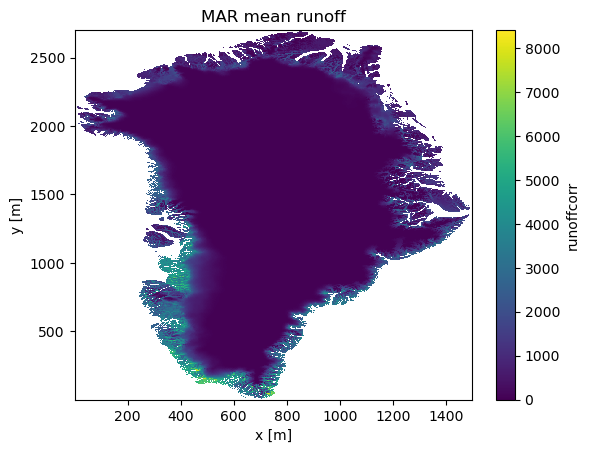

Text(0.5, 1.0, 'MAR mean runoff')

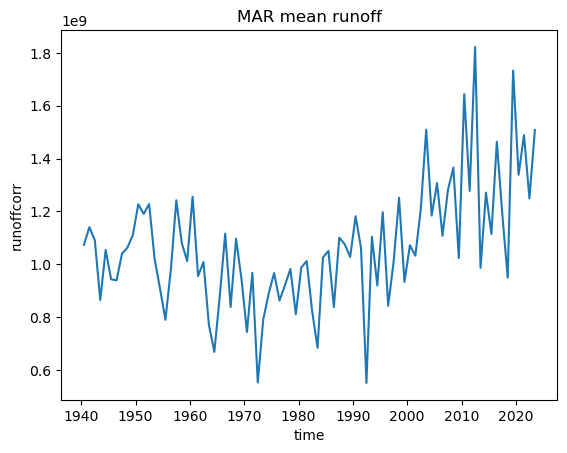

In [7]:

ds_run_MAR = open_compressed_xarray(folder + "runoff.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz")
ds_run_MAR['years_since_19400115'] = ds_run_MAR.time
ds_run_MAR['time'] = convert_months_to_date(ds_run_MAR['years_since_19400115'], '1940-01-15')

ds_run_MAR['runoffcorr'].mean(dim=['time']).plot()
plt.title("MAR mean runoff")
plt.show()
ds_run_MAR['runoffcorr'].sum(dim=['x', 'y']).plot()
plt.title("MAR mean runoff")

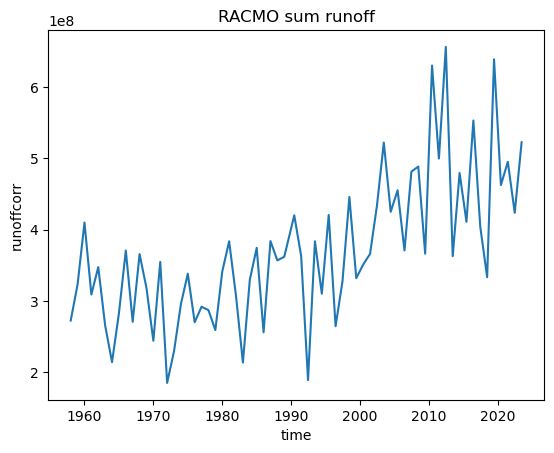

Text(0.5, 1.0, 'RACMO mean runoff')

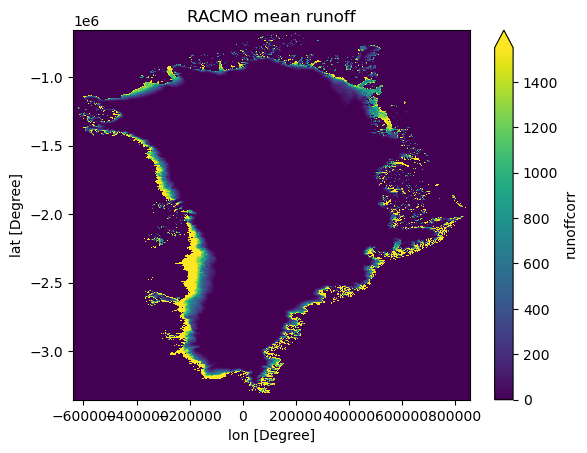

In [8]:
ds_run_RACMO = open_compressed_xarray(folder+ "runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz")
ds_run_RACMO['years_since_19580115'] = ds_run_RACMO.time
ds_run_RACMO['time'] = convert_years_to_date(ds_run_RACMO['years_since_19580115'], '1958-01-15')
ds_run_RACMO['runoffcorr'].sum(dim=['x', 'y']).plot()

plt.title("RACMO sum runoff")
plt.show()
ds_run_RACMO['runoffcorr'].mean(dim=['time']).plot(robust=True)
plt.title("RACMO mean runoff")


## Comparison Runoff

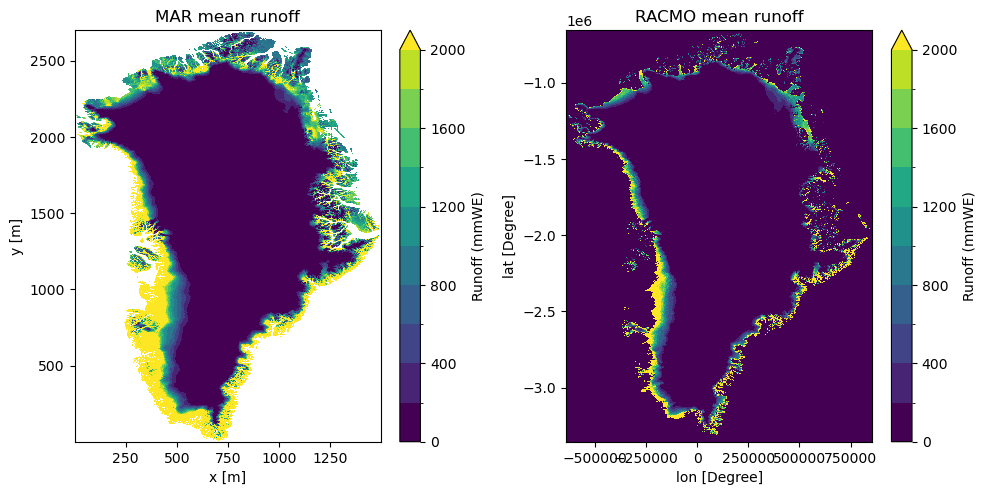

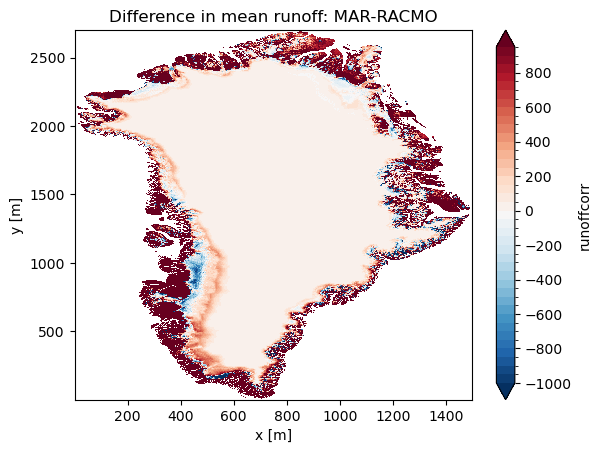

Text(0.5, 1.0, 'Runoff sum')

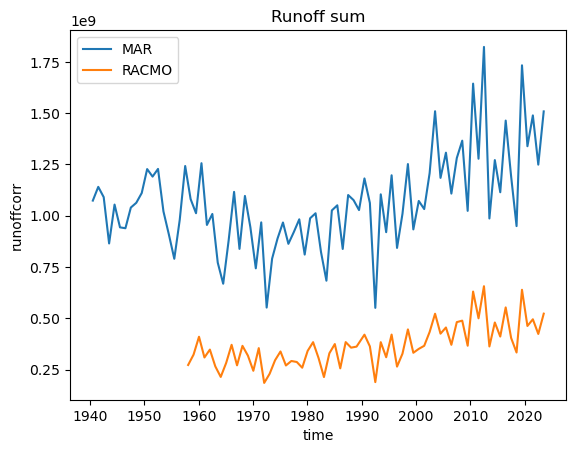

In [94]:
# compare the mean runoff of the two models

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ds_run_RACMO['runoffcorr'].sel(time=slice('2010-01-01', '2024-01-01')).mean(dim=['time']).plot(ax=axs[1], label='RACMO mean runoff since 1990', levels = np.arange(0,2200, 200), cbar_kwargs={'label': 'Runoff (mmWE)'})
ds_run_MAR['runoffcorr'].sel(time=slice('2010-01-01', '2024-01-01')).mean(dim=['time']).plot(ax=axs[0], label='MAR mean runoff since 1990', levels = np.arange(0,2200, 200), cbar_kwargs={'label': 'Runoff (mmWE)'})

plt.tight_layout()
axs[0].set_title("MAR mean runoff")
axs[1].set_title("RACMO mean runoff")

plt.show()

# difference
mean_runoff_MAR = ds_run_MAR['runoffcorr'].sel(time=slice('2010-01-01', '2023-01-01')).mean(dim=['time'])
mean_runoff_RACMO = ds_run_RACMO['runoffcorr'].sel(time=slice('2010-01-01', '2023-01-01')).mean(dim=['time'])
(mean_runoff_MAR - mean_runoff_RACMO.values).plot(levels = np.arange(-1000,1000, 50))
plt.title("Difference in mean runoff: MAR-RACMO")
plt.show()

fig,ax = plt.subplots()
ds_run_MAR['runoffcorr'].sum(dim=['x', 'y']).plot(ax=ax, label='MAR')
ds_run_RACMO['runoffcorr'].sum(dim=['x', 'y']).plot(ax=ax, label='RACMO')
plt.legend()
plt.title("Runoff sum")



In [61]:


# Create an empty DataArray with the same dimensions and coordinates
da_regions_MAR = xr.zeros_like(ds_run_MAR['runoffcorr'].isel(time=0)).rename('Basins')
da_regions_MAR.values = ds_adj_sect['section_numbers_adjusted'].values

da_regions_RACMO = xr.zeros_like(ds_run_RACMO['runoffcorr'].isel(time=0)).rename('Basins')
da_regions_RACMO.values = ds_adj_sect['section_numbers_adjusted'].values
da_regions_RACMO

<xarray.DataArray 'Basins' (y: 2700, x: 1496)> Size: 32MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     datetime64[ns] 8B 1958-01-15
  * x        (x) float32 6kB -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y        (y) float32 11kB -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Attributes:
    standard_name:  Downscaled_runoff
    long_name:      Downscaled runoff
    units:          mmWE
    actual_range:   [    0.    15083.506]

In [77]:
ds_masks1k['Promicemask'] >= 1

<xarray.DataArray 'Promicemask' (y: 2700, x: 1496)> Size: 4MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x        (x) float32 6kB 5.0 10.0 15.0 20.0 ... 7.47e+03 7.475e+03 7.48e+03
  * y        (y) float32 11kB 5.0 10.0 15.0 20.0 ... 1.349e+04 1.35e+04 1.35e+04

In [88]:
ds_run_MAR_region = ds_run_MAR['runoffcorr'].where((ds_masks1k['Promicemask'] >= 1).values).sel(time=slice('1990-01-01', '2024-01-01')).groupby(da_regions_MAR).sum()
ds_run_RACMO_region = ds_run_RACMO['runoffcorr'].sel(time=slice('1990-01-01', '2024-01-01')).groupby(da_regions_RACMO).sum()

# ds_run_RACMO['runoffcorr'].sel(time=slice('1990-01-01', '2024-01-01')).mean(dim=['time']).plot(ax=axs[1], label='RACMO mean runoff since 1990', levels = np.arange(0,2000, 200), cbar_kwargs={'label': 'Runoff (mmWE)'})

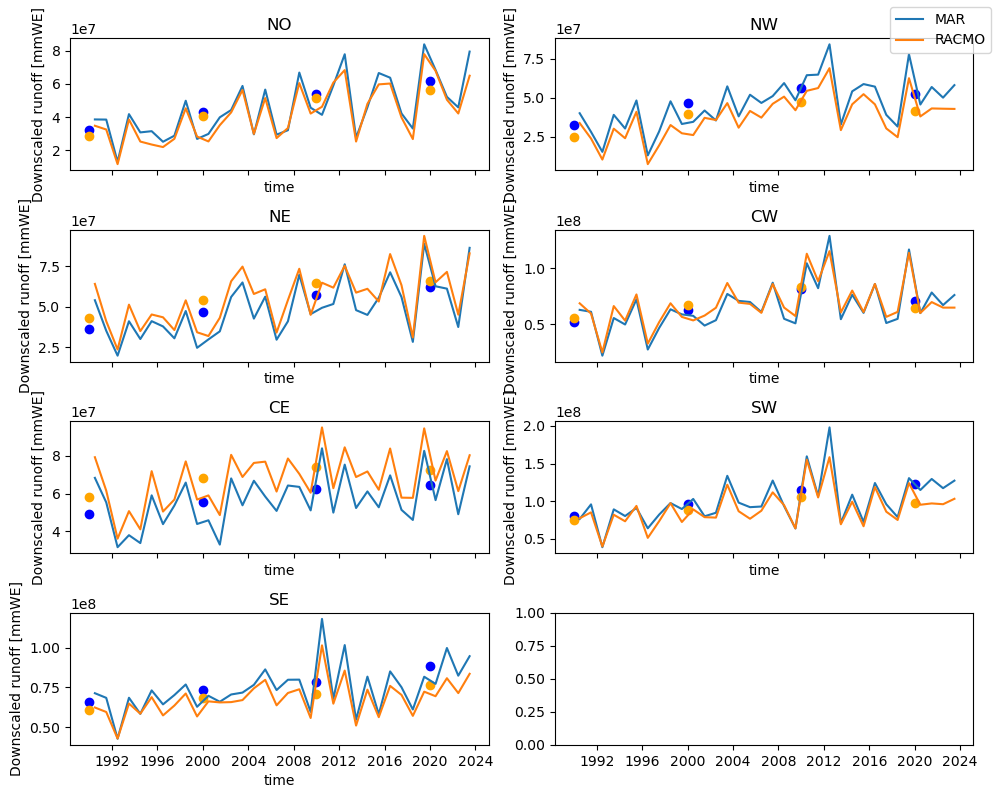

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ds_run_MAR_region and ds_run_RACMO_region are already defined and loaded

dict_sections = dict(zip(np.arange(1, 8), ['SE', 'SW', 'CE', 'CW', 'NE', 'NW', 'NO']))

fig, axs = plt.subplots(4, 2, figsize=(10, 8), sharex=True, sharey=False)
for i, basin in enumerate(ds_run_RACMO_region['Basins'].values[::-1]):
    ax = axs.flatten()[i]
    
    # Plot MAR and RACMO data
    ds_run_MAR_region.sel(Basins=basin).plot(ax=ax, label='MAR')
    ds_run_RACMO_region.sel(Basins=basin).plot(ax=ax, label='RACMO')
    
    # Calculate and plot 10-year means for MAR
    mar_10yr_mean = ds_run_MAR_region.sel(Basins=basin).resample(time='10YS').mean()
    ax.scatter(mar_10yr_mean.time.values, mar_10yr_mean.values, color='blue', marker='o')
    
    # Calculate and plot 10-year means for RACMO
    racmo_10yr_mean = ds_run_RACMO_region.sel(Basins=basin).resample(time='10YS').mean()
    ax.scatter(racmo_10yr_mean.time.values, racmo_10yr_mean.values, color='orange', marker='o')    
    # Set title
    ax.set_title(dict_sections[basin])

# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

# Precipitation

In [10]:
ds_precip_RACMO = open_compressed_xarray(folder + "precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz")
ds_precip_RACMO["year_since_19580115"] = ds_precip_RACMO.time
assert "1958-01-15" in ds_precip_RACMO.time.units, "The start date '1958-01-15' is not in the time units."

ds_precip_MAR = open_compressed_xarray(folder + "precip.1940-2023.MARv3.14-ERA5.1km.YY.nc.gz")
ds_precip_MAR["months_since_19400115"] = ds_precip_MAR.time 
assert "1940-01-15" in ds_precip_MAR.time.units, "The start date '1940-01-15' is not in the time units."

time_line_MAR = convert_months_to_date(ds_precip_MAR["months_since_19400115"], "1940-01-15")
ds_precip_MAR['time'] = time_line_MAR

time_line_RACMO = convert_years_to_date(ds_precip_RACMO["year_since_19580115"], "1958-01-15")
ds_precip_RACMO['time'] = time_line_RACMO



## Comparison Precipitation

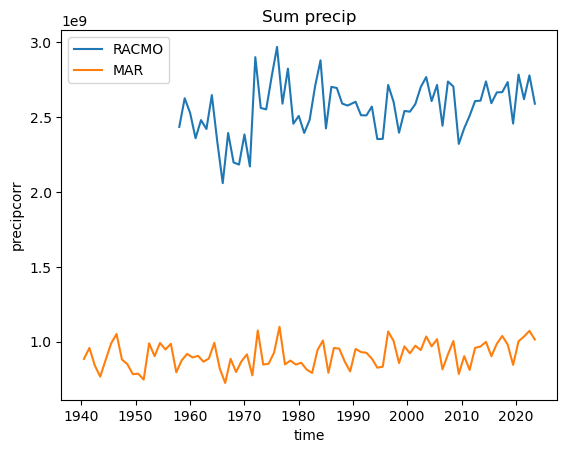

In [11]:
fig, ax = plt.subplots()
ds_precip_RACMO['precipcorr'].sum(dim=['x', 'y']).plot( label = "RACMO", ax=ax)
ds_precip_MAR['precipcorr'].sum(dim=['x', 'y']).plot( label = "MAR", ax=ax)
plt.legend()
plt.title("Sum precip")
plt.show()


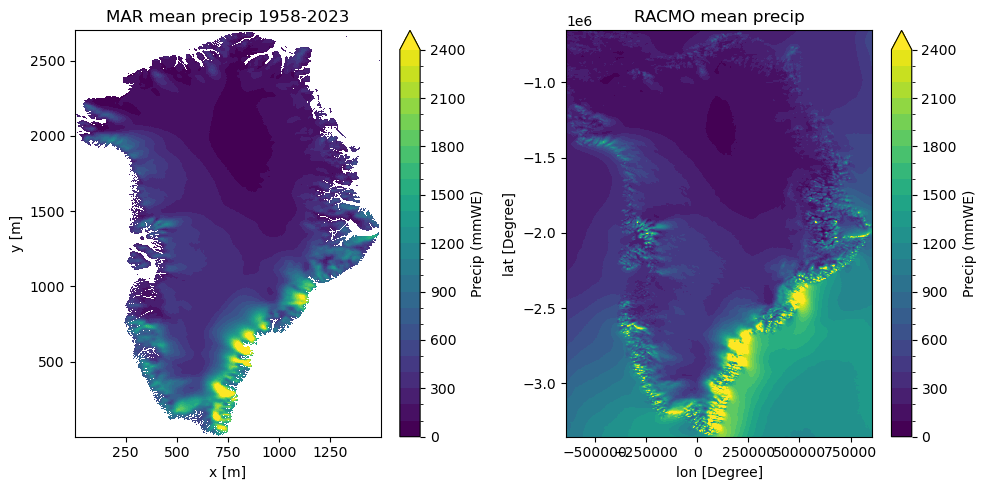

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ds_precip_MAR['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time']).plot( ax=axs[0], levels = np.arange(0,2500,100), cbar_kwargs={'label': 'Precip (mmWE)'})
axs[0].set_title("MAR mean precip 1958-2023")

ds_precip_RACMO['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time']).plot( ax=axs[1], levels = np.arange(0,2500,100), cbar_kwargs={'label': 'Precip (mmWE)'})
axs[1].set_title("RACMO mean precip")
plt.tight_layout()
plt.show()
# difference plot




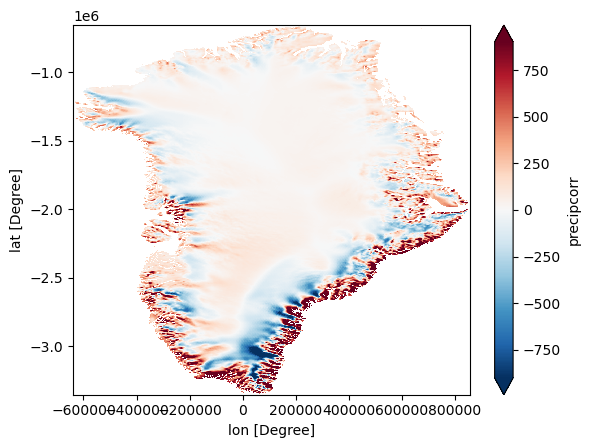

In [13]:
mean_precip_RACMO = (ds_precip_RACMO['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time']))
mean_precip_MAR=  ds_precip_MAR['precipcorr'].sel(time=slice(pd.to_datetime('1958-01-01'), pd.to_datetime('2024-01-01'))).mean(dim=['time'])
(mean_precip_RACMO - mean_precip_MAR.values).plot(robust=True)

In [14]:
mean_precip_MAR

<xarray.DataArray 'precipcorr' (y: 2700, x: 1496)> Size: 16MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 6kB 1.0 2.0 3.0 4.0 ... 1.494e+03 1.495e+03 1.496e+03
  * y        (y) float32 11kB 1.0 2.0 3.0 4.0 ... 2.698e+03 2.699e+03 2.7e+03

In [16]:
ds_masks1k

<xarray.Dataset> Size: 355MB
Dimensions:           (time: 1, x: 1496, y: 2700)
Coordinates:
  * time              (time) float32 4B 0.0
  * x                 (x) float32 6kB 5.0 10.0 15.0 ... 7.475e+03 7.48e+03
  * y                 (y) float32 11kB 5.0 10.0 15.0 ... 1.35e+04 1.35e+04
Data variables: (12/18)
    LON               (y, x) float32 16MB ...
    LAT               (y, x) float32 16MB ...
    Icemask           (y, x) float32 16MB ...
    Promicemask       (y, x) float32 16MB ...
    Topography        (y, x) float32 16MB ...
    GrIS              (y, x) float32 16MB ...
    ...                ...
    LSM_Qeqertarsuaq  (y, x) float32 16MB ...
    fjords_all        (y, x) float32 16MB ...
    LSM_average       (y, x) float64 32MB ...
    fjords            (y, x) float64 32MB ...
    small_clusters    (y, x) int64 32MB ...
    fjords_no_qqt     (y, x) int64 32MB ...
Attributes:
    title:                      Daily Surface mass balance field (RACMO2.3)
    institution:                ULg (Xavier Fettweis)
    grid:                       Map Projection:Polar Stereographic Ellipsoid ...
    history:                    Mon Aug 10 13:33:00 2020: ncks -v Easting,Nor...
    netcdf:                     4.3.2 of Jan  5 2015 11:27:10 $
    NCO:                        netCDF Operators version 4.8.0 (Homepage = ht...
    history_of_appended_files:  Mon Aug 10 13:33:00 2020: Appended file GIMP_...

In [17]:
ds_precip_RACMO['basin_nr']= ds_precip_RACMO['precipcorr'].isel(time=0).copy(deep=True)
ds_precip_RACMO['basin_nr'].values = ds_adj_sect['section_numbers_adjusted'].values
ds_precip_RACMO['Tundra'] = ds_precip_RACMO['basin_nr'].copy(deep=True)
ds_precip_RACMO['Tundra'].values = ds_masks1k['LSM'].where(ds_masks1k['Promicemask'] == 0).values
ds_precip_RACMO['Tundra_basins_nr']=ds_precip_RACMO['basin_nr'].where(ds_precip_RACMO['Tundra'] == 1)

In [18]:
ds_precip_RACMO_Tundra_basins = ds_precip_RACMO['precipcorr'].groupby(ds_precip_RACMO['Tundra_basins_nr']).mean()

In [19]:
df['time'].dt.month

NameError: name 'df' is not defined

In [126]:
import pandas as pd
import numpy as np
import xarray as xr
import plotly.express as px
from scipy.stats import linregress

dict_sections = dict(zip(np.arange(1,8),['SE', 'SW', 'CE', 'CW', 'NE', 'NW', 'NO']))

start_linear_fit = '1960-01-01'

# Convert the xarray.Dataset to a pandas.DataFrame
df = ds_precip_RACMO_Tundra_basins.to_dataframe().reset_index()
# map the basin numbers to the basin names
df['Tundra_basins_nr'] = df['Tundra_basins_nr'].astype(int)
df['Tundra_basins_nr'] = df['Tundra_basins_nr'].map(dict_sections)

# Plot the data using plotly.express
fig = px.line(df, x='time', y='precipcorr', color='Tundra_basins_nr', title='Precipitation over Time')

# Extract the colors used by plotly.express
color_map = {trace.name: trace.line.color for trace in fig.data if trace.mode == 'lines'}
# condition_month =  df['time'].dt.month.isin([6,7,8])
time_conditon = df['time'] > start_linear_fit


# Add a linear fit with slope and p-value
for basin in df['Tundra_basins_nr'].unique():
    print(df)
    df_basin = df[(df['Tundra_basins_nr'] == basin)& condition_month]
    print(df_basin)
    years_since_start = ((df_basin['time'] - df_basin['time'].iloc[0]).dt.days / 365.25).astype(int)
    slope_yrs, intercept, r_value, p_value_yrs, std_err = linregress(years_since_start, df_basin['precipcorr'])
    slope, intercept, r_value, p_value, std_err = linregress(df_basin['time'].astype(int), df_basin['precipcorr'])
    # Create the label with conditional bold formatting
    if p_value_yrs < 0.01:
        label = f'<b>Fit {basin} (slope={slope_yrs:.2f} mm/yr, p={p_value_yrs:.3f})</b>'
    else:
        label = f'Fit {basin} (slope={slope_yrs:.2f} mm/yr, p={p_value_yrs:.3f})'
    
    fig.add_scatter(
        x=df_basin['time'],
        y=intercept + slope * df_basin['time'].astype(int),
        mode='lines',
        name=label,
        line=dict(color=color_map[str(basin)], dash='dash', width=2)  # Customize line style and width
    )

# Show the plot
fig.show()

df

          time Tundra_basins_nr   precipcorr
0   1958-01-15               SE  2148.175537
1   1958-01-15               SW   781.911011
2   1958-01-15               CE   918.429138
3   1958-01-15               CW   449.722900
4   1958-01-15               NE   427.475342
..         ...              ...          ...
457 2023-07-01               CE   838.377869
458 2023-07-01               CW   692.919678
459 2023-07-01               NE   405.553528
460 2023-07-01               NW   555.108826
461 2023-07-01               NO   233.761520

[462 rows x 3 columns]
          time Tundra_basins_nr   precipcorr
224 1990-06-30               SE  1976.791748
231 1991-06-30               SE  1914.191650
238 1992-06-29               SE  1691.428101
245 1993-06-30               SE  1813.252441
252 1994-06-30               SE  1522.006226
259 1995-06-30               SE  1702.106445
266 1996-06-29               SE  2197.104736
273 1997-06-30               SE  1825.658936
280 1998-06-30               SE

/Users/annek/opt/anaconda3/envs/phdIIfresh/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



,time,Tundra_basins_nr,precipcorr
0,1958-01-15,SE,2148.175537
1,1958-01-15,SW,781.911011
2,1958-01-15,CE,918.429138
3,1958-01-15,CW,449.722900
4,1958-01-15,NE,427.475342
...,...,...,...
457,2023-07-01,CE,838.377869
458,2023-07-01,CW,692.919678
459,2023-07-01,NE,405.553528
460,2023-07-01,NW,555.108826


In [128]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:       (time: 1012, nblock1: 40, nblock2: 400, bnds: 2, rlat: 566,
                   rlon: 438, height: 1)
Coordinates:
  * height        (height) float64 8B 0.0
    lat           (rlat, rlon) float64 2MB ...
    lon           (rlat, rlon) float64 2MB ...
  * rlat          (rlat) float64 5kB -14.4 -14.35 -14.3 ... 13.75 13.8 13.85
  * rlon          (rlon) float64 4kB -10.05 -10.0 -9.95 -9.9 ... 11.7 11.75 11.8
  * time          (time) datetime64[ns] 8kB 1939-09-15T12:00:00 ... 2023-12-16
Dimensions without coordinates: nblock1, nblock2, bnds
Data variables:
    assigned      (time) int32 4kB ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    date_bnds     (time, bnds) int32 8kB ...
    dir           (rlat, rlon) float64 2MB ...
    dtg           (time) int32 4kB ...
    hms_bnds      (time, bnds) int32 8kB ...
    rotated_pole  float32 4B ...
    runoff        (time, height, rlat, rlon) float32 1GB ...
    time_bnds     (time, bnds) datetime64[ns] 16kB ...
Attributes:
    Conventions:   CF-1.4
    source:        RACMO2
    Domain:        FGRN055
    Experiment:    BN_RACMO2.3p2_ERA5_3h_1940_FGRN055
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    CreationDate:  Tue Apr 11 19:36:56 2023
    comment:       asim2cdf: cpar=runoff, iwmo=160, ilvt=105, ilev=0, idh=24,...
    title:         Total Runoff Flux
    NCO:           netCDF Operators version 5.1.9 (Homepage = http://nco.sf.n...
    history:       Thu Aug 29 19:38:08 2024: ncrcat -O /ec/res4/scratch/rug/e...

In [24]:
ds_run_RACMO.sel(time='2023-01').runoffcorr.plot()

TypeError: No numeric data to plot.

In [25]:
ds_run_RACMO

<xarray.Dataset> Size: 1GB
Dimensions:               (time: 66, x: 1496, y: 2700)
Coordinates:
  * time                  (time) datetime64[ns] 528B 1958-01-15 ... 2023-07-01
  * x                     (x) float32 6kB -6.39e+05 -6.38e+05 ... 8.56e+05
  * y                     (y) float32 11kB -3.355e+06 -3.354e+06 ... -6.556e+05
Data variables:
    runoffcorr            (time, y, x) float32 1GB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    years_since_19580115  (time) float32 264B 0.0 1.0 2.0 ... 63.46 64.46 65.46
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  IMAU (Brice Noel)
    title:        Annual cumulated field, B. Noel (IMAU)
    netcdf:       4.4.1.1 of Nov 25 2017 10:57:26 $
    NCO:          netCDF Operators version 4.8.0 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...